In [1]:
import seaborn as sns
from datetime import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# user_spec과 loan_result의 일부 열을 join하여 user의 application별 신청 여부를 가져온다.

loan_result = pd.read_csv("loan_result.csv")
user_spec = pd.read_csv("user_spec.csv")[['application_id','user_id']]
user_app=loan_result.groupby('application_id').max()[['is_applied']].join(user_spec,how="outer")

In [3]:
# user의 정보를 가져온다.
userlist = pd.read_csv('userlist.csv',index_col=0)

In [4]:
# is_applied 정보가 포함된 log에사 대출 조회와 관련된 event만 가져와, (대출 조회 성공은 1, 중도 종료는 0)으로 mapping한다.
alllog = pd.read_csv('alllog.csv')
alllog['newevent'] = alllog[
    alllog['event'].isin(
        ['ViewLoanApply','StartLoanApply',
        'CompleteIDCertification','IsApplied',
        'NotApplied']
    )
]['event'].map(
    {'ViewLoanApply':0,'StartLoanApply':0,
     'CompleteIDCertification':0,'IsApplied':1,
     'NotApplied':1}
)
alllog = alllog.dropna()[['user_id','newevent']]

In [5]:
# 대출성사비율 파생변수 생성하여 전체 데이터에 feature로 추가
app_rate = pd.DataFrame()
app_rate['app_rate'] = user_app.groupby('user_id').mean()['is_applied']
app_rate['user_id'] = user_app.groupby('user_id').count().index
app_rate = app_rate.reset_index(drop = True)
fulllist = pd.merge(userlist,app_rate,on ='user_id')

In [6]:
# 조회완료비율 파생변수 생성하여 전체 데이터에 feature로 추가
finishrate = pd.DataFrame()
finishrate['finishrate'] = (alllog.groupby('user_id').sum()['newevent'])/(alllog.groupby('user_id').count()['newevent']-alllog.groupby('user_id').sum()['newevent'])
finishrate['finishrate'] = finishrate['finishrate'].apply(lambda x: 1 if str(x)=='inf' else x)
finishrate['user_id'] = alllog.groupby('user_id').count().index
finishrate = finishrate.reset_index(drop = True)
fulllist = pd.merge(fulllist,finishrate,on ='user_id')

In [7]:
# session별로 log_data를 묶은 데이터를 가져와 각 user의 평균 session 길이, 총 시간, 본인인증 여부를 연산한다.
session = pd.read_csv("session.csv",)
session['sessionlength'] = pd.to_timedelta(session.sessionlength).dt.total_seconds()
session = session.drop(
    session[session['sessionlength']<=3].index
)
temp=session.groupby(['user_id']).count()
user_time=temp[['sessionnum']]

user_time['certificate'] = session.groupby(['user_id']).sum()['CompleteIDCertification'].apply(
    lambda x: 1 if x > 0 else 0
)
user_time['totaltime'] = session.groupby(['user_id']).sum()['sessionlength']
user_time['averagedur'] = user_time['totaltime']/user_time['sessionnum']
user_time['user_id'] = user_time.index
user_time = user_time.reset_index(drop = True)

<ipython-input-7-bffe5c8c337e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_time['certificate'] = session.groupby(['user_id']).sum()['CompleteIDCertification'].apply(
<ipython-input-7-bffe5c8c337e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_time['totaltime'] = session.groupby(['user_id']).sum()['sessionlength']
<ipython-input-7-bffe5c8c337e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [8]:
# 나머지 user 정보에 합친다.
fulllist = pd.merge(
    fulllist,
    user_time[['user_id','sessionnum','averagedur','certificate']],
    on ='user_id'
)
fulllist = fulllist.dropna()

In [9]:
# 나이, 근속연수 열 추가 등 전처리
fulllist['age'] = pd.to_datetime(fulllist['birth_year']).apply(lambda x: 2022 - x.year)
fulllist['desired_amount'] = fulllist['desired_amount'].apply(lambda t: np.log10(t+1))
fulllist['yearly_income'] = fulllist['yearly_income'].apply(lambda t: np.log10(t+1))
fulllist['existing_loan_amt'] = fulllist['existing_loan_amt'].apply(lambda t: np.log10(t+1))
fulllist['seniority'] = pd.to_datetime(fulllist['company_enter_month']).apply(lambda x: 2022 - x.year)

In [10]:
import numpy as np

def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

In [11]:
gini(fulllist['finishrate'])

0.45446731730525824

In [25]:
fulllist = fulllist.drop(['index'],axis = 1)

<AxesSubplot:>

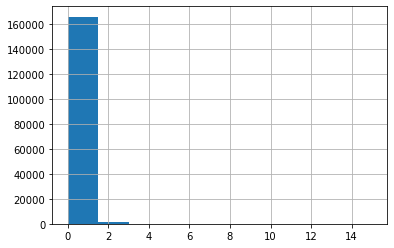

In [13]:
fulllist['finishrate'].hist()

In [15]:
fulllist

,index,user_id,birth_year,gender,insert_time,credit_score,yearly_income,income_type,company_enter_month,employment_type,...,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt,app_rate,finishrate,sessionnum,averagedur,certificate,age,seniority
2,8981419,250296,1999-01-01,1.0,2022-06-30 23:51:58,620.0,7.380211,EARNEDINCOME,2022-04-01,계약직,...,0.0,7.0,7.255273,0.000000,1.000000,5,184.400000,1,23,0
3,4389945,860895,1975-01-01,1.0,2022-06-30 23:51:26,650.0,7.556303,EARNEDINCOME,2020-12-01,정규직,...,0.0,9.0,8.627366,1.000000,0.206897,27,88.037037,1,47,2
4,8953384,435110,1996-01-01,1.0,2022-06-30 23:51:13,780.0,7.653213,EARNEDINCOME,2022-01-01,계약직,...,0.0,1.0,6.000000,0.000000,0.000000,2,216.000000,0,26,0
5,8976932,118506,1985-01-01,0.0,2022-06-30 23:51:02,610.0,7.591065,EARNEDINCOME,2021-06-01,정규직,...,0.0,5.0,7.929419,0.500000,0.400000,36,502.361111,1,37,1
6,4451049,468436,1981-01-01,0.0,2022-06-30 23:50:58,660.0,7.556303,EARNEDINCOME,2016-04-01,정규직,...,0.0,6.0,7.806180,0.333333,0.200000,24,453.375000,1,41,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268425,827725,254001,1968,1.0,2022-03-01 00:21:03,580.0,1.612784,EARNEDINCOME,2019-07-01,정규직,...,0.0,0.0,0.000000,1.000000,0.500000,2,139.500000,1,54,3
268427,2660180,93868,1971,0.0,2022-03-01 00:17:09,650.0,1.397940,EARNEDINCOME,2022-02-01,계약직,...,0.0,5.0,2.503791,0.000000,0.333333,6,11771.000000,1,51,0
268428,1028761,661317,1994-01-01,0.0,2022-03-01 00:17:06,200.0,7.477121,EARNEDINCOME2,2021-04-01,정규직,...,0.0,1.0,7.301030,0.000000,1.000000,1,57.000000,0,28,1
268429,2978803,334783,1984-01-01,1.0,2022-03-01 00:15:22,830.0,7.778151,PRIVATEBUSINESS,2016-08-01,정규직,...,0.0,1.0,0.000000,0.000000,1.000000,1,1440.000000,0,38,6


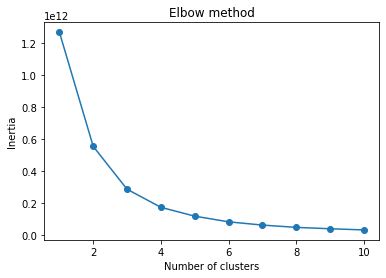

In [26]:
from sklearn.cluster import KMeans
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(fulllist.drop(
        [
            'user_id','birth_year','company_enter_month',
            'income_type','employment_type',
            'houseown_type','purpose','insert_time'
        ],
        axis=1
    ))
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [33]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(fulllist.drop(
    ['user_id','birth_year','company_enter_month',
     'income_type','employment_type',
     'houseown_type','purpose','insert_time','averagedur'],
    axis=1
))

KMeans(n_clusters=3)

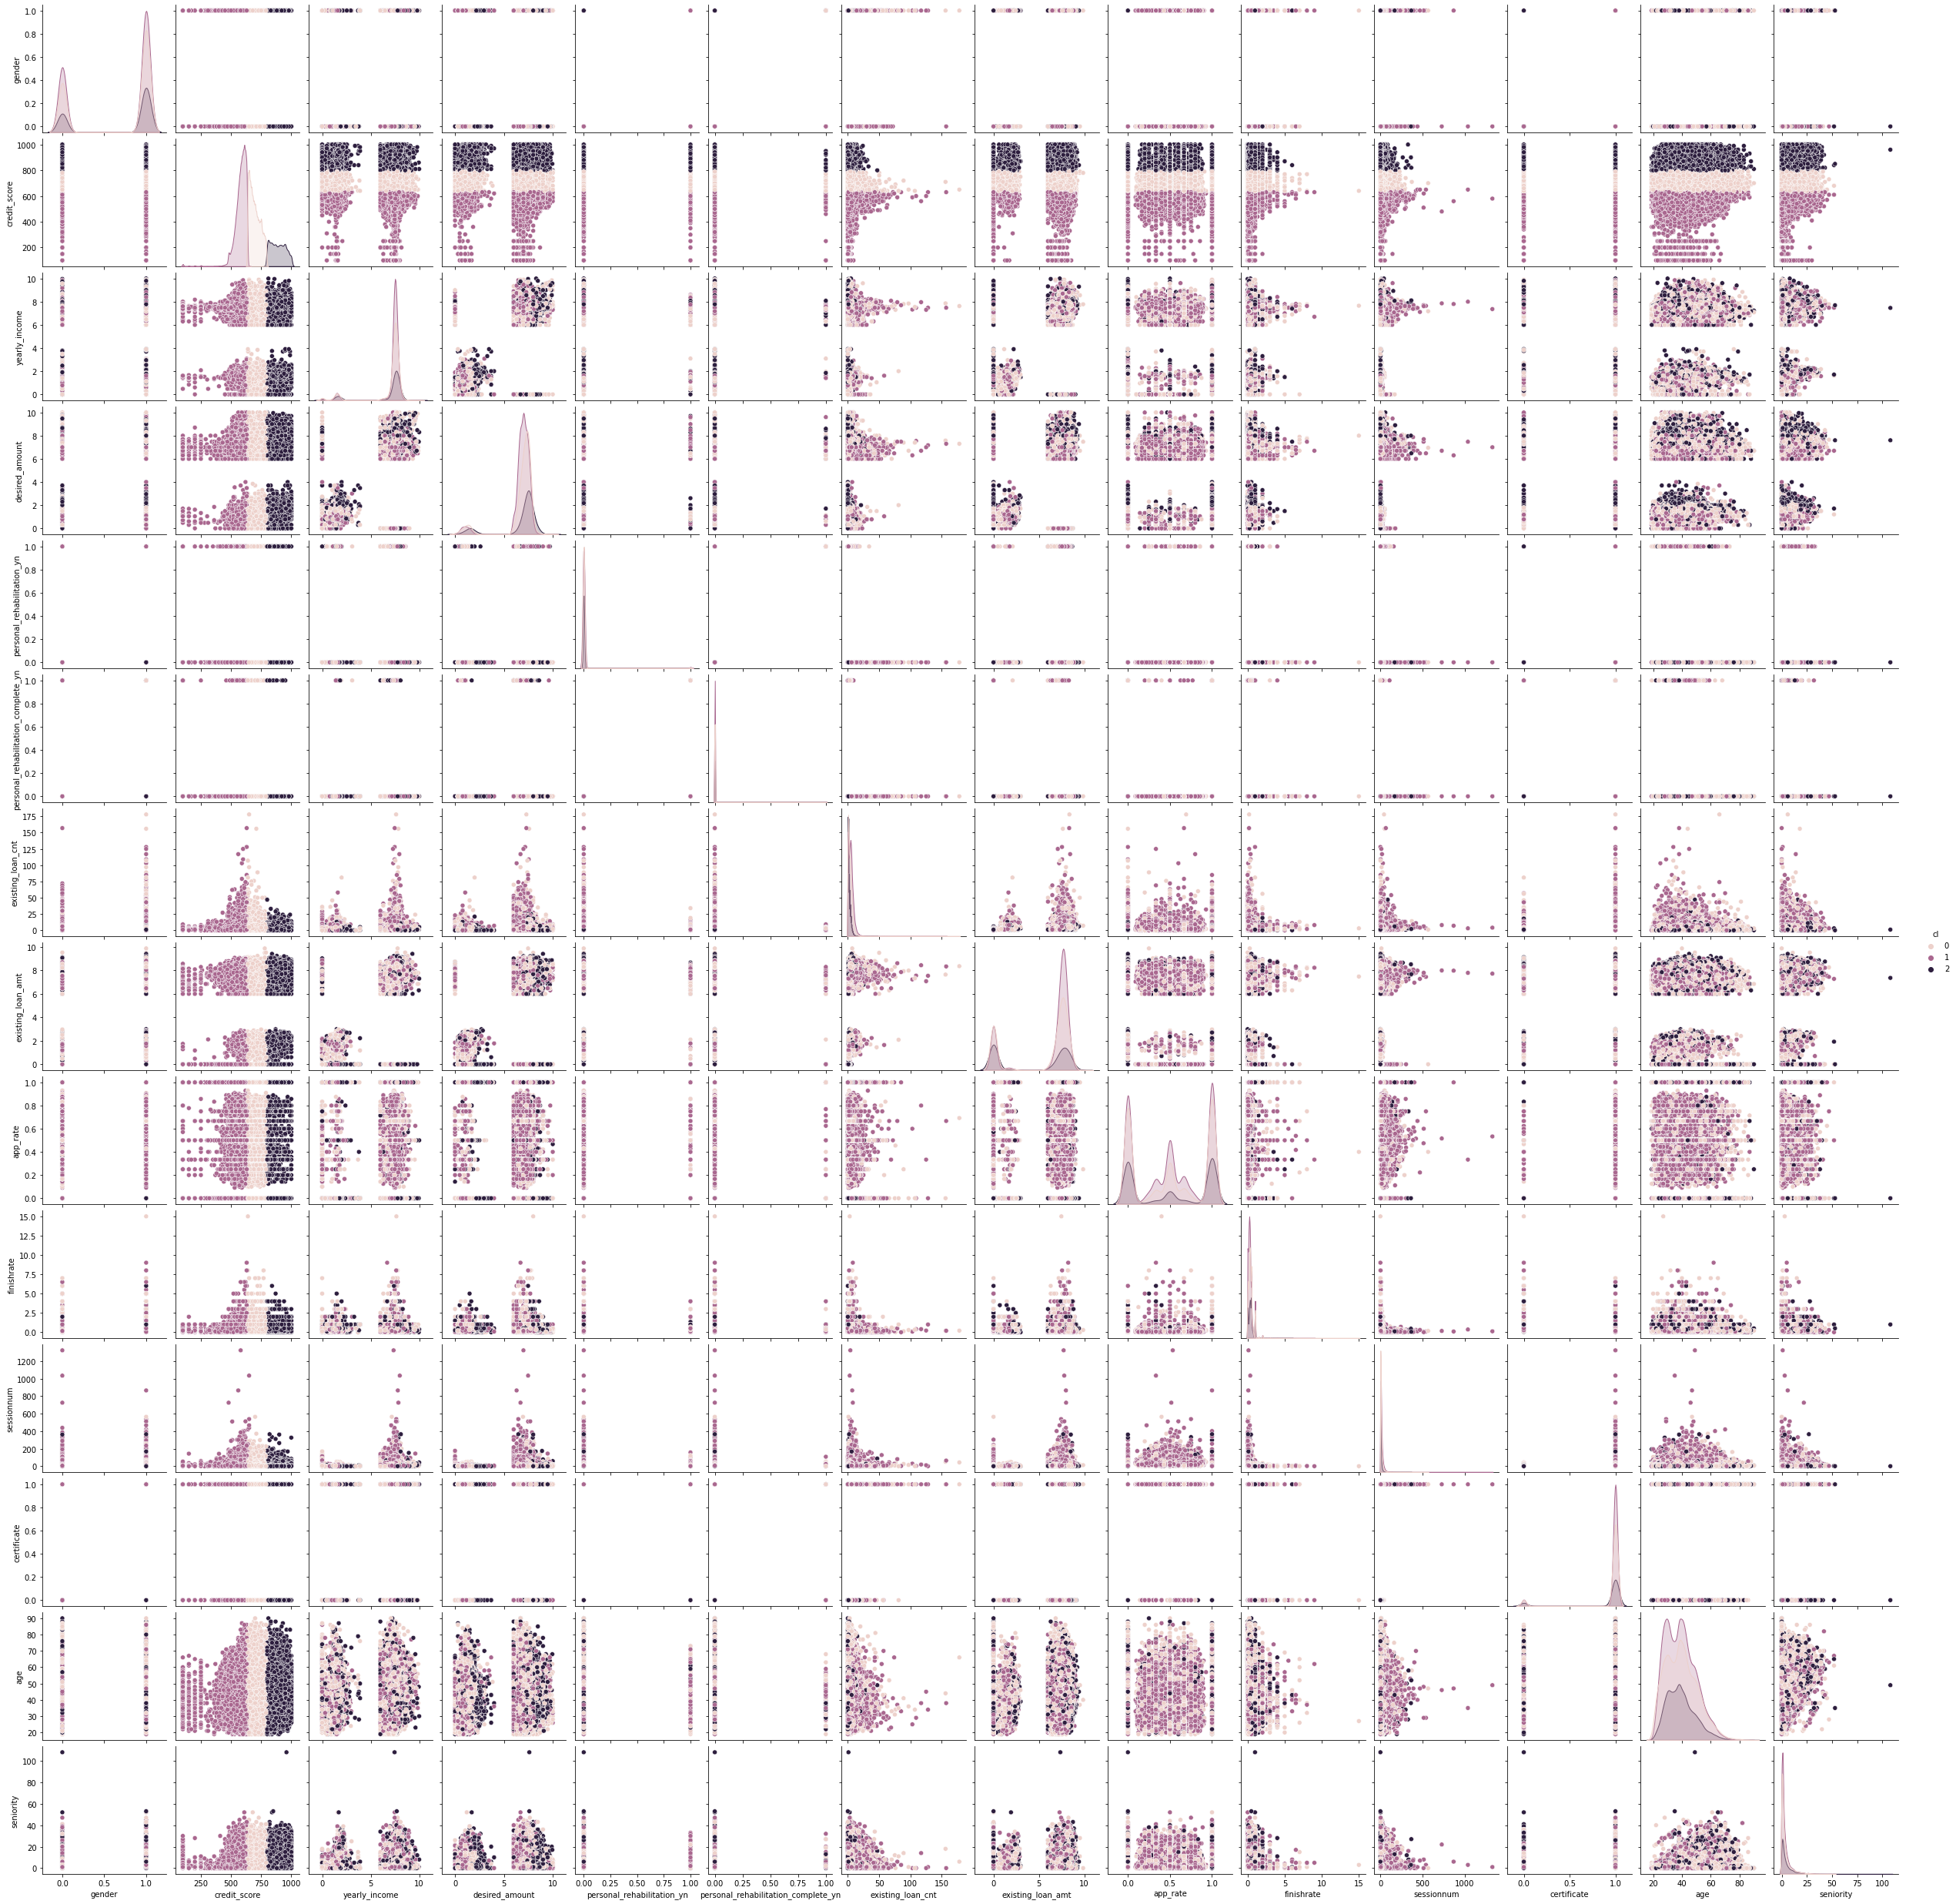

In [35]:
klist = fulllist.drop(
    ['user_id','birth_year','company_enter_month',
     'income_type','employment_type',
     'houseown_type','purpose','insert_time','averagedur'],
    axis=1
)
klist['cl'] = kmeans.labels_
sns.pairplot(klist,hue='cl')